In [1]:
import itertools
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
from math import *
import scipy
from tqdm import tqdm
import copy
import seaborn as sns

from utils import *
from lag_test_utils import *
from scipy.optimize import root_scalar

import matplotlib as mpl
import pandas as pd
import multiprocessing

# Set the default font and size
# mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 14

In [2]:
def G_mat_hwa(spc_list, dep_order):
    '''
    spc: species obbject list of length N=R
    dep_order: array([R])
    '''
    R = len(dep_order)
    N = R
    G = np.zeros([N, R])
    for i_n, spc in enumerate(spc_list):
        for i_t in range(R):
            Rs = np.array([1*(res+1 in dep_order[i_t:]) for res in range(R)])
            spc.lag_left=0
            spc.GetEating(Rs)
            G[i_n, i_t] = spc.GetGrowthRate()            
    return G

def NicheGrowthState(spcs, dep_order, t_order):
    '''
    spcs: list of species (object; SeqUt_alt or CoUt_alt) 
    dep_order: np array; order of resources (1 to R) depleted
    t_order: np array; time spans of each temporal niche. 
    '''
    # RE: resource_eating for [spc, niche], 
    # in an np array with boolean list of elements
    N, R = len(spcs), len(dep_order)
    RE = np.zeros([N, R], dtype=object)
    for i_n in range(N):
        for i_t in range(R):
            Rs = np.zeros(R)
            for res in dep_order[i_t:]:
                Rs[res-1] = 1
            spcs[i_n].lag_left = 0
            spcs[i_n].GetEating(Rs)
            RE[i_n, i_t] = spcs[i_n].eating
    # here we define a niche growth state matrix S, whose elements can be 0, 1, or 2
    # 0 means no growth; 1 means growth during full niche; 2 means part of of niche is taken by lag
    # and define a tau_mod - the lag time in each niche for those 2 elements in S. 
    # initialize by all niche - all growth
    S = np.ones([N, R])
    tau_mod = np.zeros([N, R])
    for i_n, spc in enumerate(spcs):
        in_lagphase = 0
        tau_new = 0
        for niche in np.arange(0, R):
            # if next time niche is a different resource, 
            # we assume the species would renew the current lag by the lagtime of
            # switching from the previous (actively consuming) nutrient to the current nutrient
            # regardless of whether it was already in the middle of a lag phase or not. 
            if(niche==0 or not np.array_equal(RE[i_n, niche], RE[i_n, niche-1])):
                # update the lag
                if(niche==0):
                    tau_new = spc.tau_init
                else:
                    Rs = np.array([int(i+1 in dep_order[niche:]) for i in range(R)]) # if res is in leftover resources then 1; else 0
                    tau_new = spc.tau_f(Rs, spc.rho, spc.tau0)
                # check if this lag outlasts the t-niche
                if(tau_new < t_order[niche]):
                    S[i_n, niche] = 2
                    tau_mod[i_n, niche] = tau_new
                    in_lagphase = 0
                else:
                    S[i_n, niche] = 0
                    tau_new -= max(0, t_order[niche])
                    in_lagphase = 1
            # if the next time niche is a same resource, 
            # when the species has not yet finished a lag, it would continue being in that lag
            # with no need to renew the lagtime value. 
            elif(in_lagphase == 1):
                if(tau_new < t_order[niche]):
                    S[i_n, niche] = 2
                    tau_mod[i_n, niche] = tau_new
                    in_lagphase = 0
                else:
                    S[i_n, niche] = 0
                    tau_new -= max(0, t_order[niche])
            # else: the spc was growing and the next niche it's eating the same stuff. S=1 and tau_mod=0. 
    return S, tau_mod

def TsolveIter(spc_list, dep_order, logD, T=24): # N = R must be ensured
    # species-niche growth state S
    N = len(spc_list)
    R = N
    S = np.ones([N, R]) * 2 # initialize S at 2. 0 is all lag in this niche and 1 is all growth
    # before the first iter
    converged = 0
    t_iter_compare = np.zeros(R)
    G = G_mat_hwa(spc_list, dep_order)
    # for the first iteration of S and tau_mod, go with all t_order=max
    S, tau_mod = NicheGrowthState(spc_list, dep_order, np.ones(R)*T)
    # to keep time short do 10 iters at most
    for count in range(10): 
        # rhs: [Gt = logD]'s rhs, vec of len R
        rhs = logD + np.diag( (G*(S>0)) @ np.transpose(tau_mod) )
        if(np.linalg.matrix_rank(G*(S>0))>=N):
            t_iter = np.linalg.inv(G*(S>0))@rhs
            # update S and tau_mod based on this set of new t_iter
            S, tau_mod = NicheGrowthState(spc_list, dep_order, t_iter)
            if ((t_iter_compare==t_iter).all() and np.sum(t_iter)<=24):
                converged = 1
                break
            t_iter_compare = t_iter
        else:
            converged = 0
            break
    return converged, t_iter_compare, S, tau_mod

def FMatLag(spcs, dep_order, t_order, S, tau_mod):
    N, R = len(spcs), len(dep_order)
    F_mat = np.zeros([N, R])
    for i_n in range(N):
        coeff = 1
        for i_t in range(R):
            Rs = np.zeros(R)
            for res in dep_order[i_t:]:
                Rs[res-1] = 1
            spcs[i_n].GetEating(Rs)
            g = spcs[i_n].GetGrowthRate()
            vec_dep = spcs[i_n].GetDep()
            if(S[i_n, i_t] == 1):
                dep = coeff * (exp(g*t_order[i_t]) - 1)
                coeff *= exp(g*t_order[i_t])
            elif S[i_n, i_t] == 2:
                dep = coeff * (exp(g*(t_order[i_t]-tau_mod[i_n, i_t])) - 1)
                coeff *= exp(g*(t_order[i_t]-tau_mod[i_n, i_t]))
            else:
                dep=0
            F_mat[i_n, :] += dep * vec_dep
    return np.transpose(F_mat)

In [210]:
# pilot test
# first generate some div=4 comms of cout/diaux and ensure that it is a real coexistence
Nmax = 1000
rho = 0.1
gmean, gsigma, gC, R, D, T_dilute = 0.5, 0.1, 1.0, 4, 1000, 24
Nseq, Ncout = 4, 0
for i in range(Nmax):
    # generate comm
    flag = 0
    g_seq = generate_g(Nseq, R, gmean, gsigma)
    g_cout = generate_g(Ncout, R, gmean, gsigma)
    permutations = list(itertools.permutations(list(range(1, R+1))))
    pref_list = np.array(random.choices(permutations, k=Nseq))
    col = np.argmax(g_seq, axis=1) # find column in g where it's the largest
    for row_i, row in enumerate(pref_list):
        index = np.where(row==col[row_i]+1)[0][0] # and switch this resource with the first-consumed one
        row[0], row[index] = row[index], row[0]
    species_list = []
    for i in range(Nseq):
        species_list.append(SeqUt_alt(rho=rho, g_enz=g_seq[i], gC=gC, pref_list=pref_list[i], biomass=0.01, id=i))
    for i in np.arange(Nseq, Nseq+Ncout):
        species_list.append(CoUt_alt(rho=rho, g_enz=g_cout[i-Nseq], gC=gC, biomass=0.01, id=i))
    tau_init_dist = lambda x: np.random.uniform(2, 3)
    tau_0_dist = lambda x: np.random.uniform(0.2, 0.4)
    for species in species_list:
        tau0 = tau_0_dist(0)
        tau_init = tau_init_dist(0)
        if(species.cat=="Seq"):
            species.SetLag(tau0, TaufSeq, tau_init)
            species.b = 0.01
        else:
            species.SetLag(tau0, TaufCout, tau_init)
            species.b = 0.01
        species.RezeroLag()
    # filter for coexistence 
    dep_orders = np.array(permutations)
    N_dep_order = len(dep_orders)
    for j in range(N_dep_order):
        dep_order = dep_orders[j]
        G = G_mat_hwa(species_list, dep_order)
        if(np.linalg.matrix_rank(G)>=Nseq+Ncout):
            converged, t_iter, S, tau_mod = TsolveIter(species_list, dep_order, logD=np.log(D), T=24)
            if(converged == 1 and sum(t_iter>0) >= len(t_iter)):
                F = FMatLag(species_list, dep_order, t_iter, S, tau_mod)
                if(abs(np.linalg.det(F))>1e-10):
                    flag = 1
                    break
    if(flag):
        break

In [211]:
F = FMatLag(species_list, dep_order, t_iter, S, tau_mod)
print("  ")
print(dep_order, "\n", t_iter, "\n", S, "\n", tau_mod, "\n", F)
print(G_mat_hwa(species_list, dep_order))

  
[4 2 3 1] 
 [9.54028068 0.37806511 0.01734713 4.63474733] 
 [[2. 1. 1. 2.]
 [2. 1. 0. 2.]
 [2. 0. 0. 2.]
 [2. 1. 1. 2.]] 
 [[2.42739625 0.         0.         1.04976594]
 [2.73685915 0.         0.         1.14489217]
 [2.50131043 0.         0.         1.1082598 ]
 [2.85127917 0.         0.         0.77191768]] 
 [[825.91978317 833.41603964 872.89192003 903.04169308]
 [  0.         165.58396036   0.           0.        ]
 [173.08021683   0.           0.          95.95830692]
 [  0.           0.         126.10807997   0.        ]]
[[0.68717532 0.68717532 0.68717532 0.48765639]
 [0.71231762 0.71231762 0.51356167 0.51356167]
 [0.68831627 0.67651823 0.67651823 0.58492126]
 [0.64568237 0.64568237 0.64568237 0.60408416]]


In [212]:
Rs = np.sum(F, axis=1)
Rs

array([3435.26943592,  165.58396036,  269.03852375,  126.10807997])

100%|████████████████████████████████████████| 200/200 [00:00<00:00, 231.97it/s]


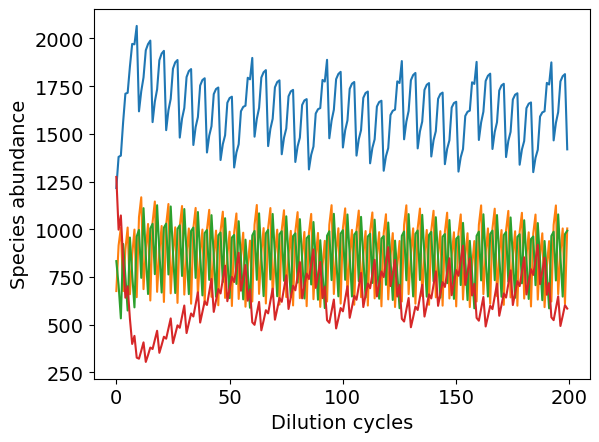

In [213]:
# test
bs = [1,1,1,1]
for idx, spc in enumerate(species_list):
    spc.b = bs[idx]
    spc.RezeroLag()
Rs = np.sum(F, axis=1)
C = EcoSystem(species_list)
b_list, id_list = [], []
for i in tqdm(range(200)):
    C.OneCycle(Rs, T_dilute)
    b_list.append(C.last_cycle['bs'][-1])
    id_list.append(C.last_cycle['ids'])
    C.MoveToNext(D)
vis_biomass(id_list, b_list)

In [20]:
# next step: generate 20 communities for each strat for each rho. see how the efficiency in single/community changes. 
Nmax = 1000
N_trials = 20
N_inv = 100
n_rho = 40
rholist = np.linspace(1e-4, 0.4, n_rho)
gmean, gsigma, gC, R, D, T_dilute = 0.5, 0.1, 1.0, 4, 1000, 24

# generate communities
Ns = [(0, 4), (4, 0)]
all_t_deps = {Npair:[] for Npair in Ns}
for Npair in all_t_deps:
    Nseq, Ncout = Npair
    for rho in tqdm(rholist):
        t_deps = []
        for idx, trial in enumerate(range(N_trials)):
            for i in range(Nmax):
                # generate comm
                flag = 0
                g_seq = generate_g(Nseq, R, gmean, gsigma)
                g_cout = generate_g(Ncout, R, gmean, gsigma)
                permutations = list(itertools.permutations(list(range(1, R+1))))
                pref_list = np.array(random.choices(permutations, k=Nseq))
                col = np.argmax(g_seq, axis=1) # find column in g where it's the largest
                for row_i, row in enumerate(pref_list):
                    index = np.where(row==col[row_i]+1)[0][0] # and switch this resource with the first-consumed one
                    row[0], row[index] = row[index], row[0]
                species_list = []
                for i in range(Nseq):
                    species_list.append(SeqUt_alt(rho=rho, g_enz=g_seq[i], gC=gC, pref_list=pref_list[i], biomass=0.01, id=N_inv+i))
                for i in np.arange(Nseq, Nseq+Ncout):
                    species_list.append(CoUt_alt(rho=rho, g_enz=g_cout[i-Nseq], gC=gC, biomass=0.01, id=N_inv+i))
                tau_init_dist = lambda x: np.random.uniform(2, 3)
                tau_0_dist = lambda x: np.random.uniform(0.2, 0.4)*2
                for species in species_list:
                    tau0 = tau_0_dist(0)
                    tau_init = tau_init_dist(0)
                    if(species.cat=="Seq"):
                        species.SetLag(tau0, TaufSeq, tau_init)
                        species.b = 0.01
                    else:
                        species.SetLag(tau0, TaufCout, tau_init)
                        species.b = 0.01
                    species.RezeroLag()
                # filter for coexistence for 4 species 
                dep_orders = np.array(permutations)
                N_dep_order = len(dep_orders)
                for j in range(N_dep_order):
                    dep_order = dep_orders[j]
                    G = G_mat_hwa(species_list, dep_order)
                    if(np.linalg.matrix_rank(G)>=Nseq+Ncout):
                        converged, t_iter, S, tau_mod = TsolveIter(species_list, dep_order, logD=np.log(D), T=24)
                        if(converged == 1 and sum(t_iter>0) >= len(t_iter)):
                            F = FMatLag(species_list, dep_order, t_iter, S, tau_mod)
                            if(abs(np.linalg.det(F))>1e-10):
                                flag=1
                                break
                if(flag): # if coexist in linalg, test it in simulation
                    bs = [1,1,1,1]
                    for jdx, spc in enumerate(species_list):
                        spc.b = bs[jdx]
                        spc.RezeroLag()
                    Rs = np.sum(F, axis=1)
                    C = EcoSystem(species_list)
                    b_list, id_list = [], []
                    for i in range(100):
                        C.OneCycle(Rs, T_dilute)
                        b_list.append(C.last_cycle['bs'][-1])
                        id_list.append(C.last_cycle['ids'])
                        C.MoveToNext(D)
                    if(len(C.last_cycle["ids"])>=R):
                        break
            t_deps.append(C.last_cycle["ts"][-2])
        all_t_deps[Npair].append(t_deps)

100%|███████████████████████████████████████████| 40/40 [08:11<00:00, 12.28s/it]


100%|████████████████████████████████████████| 200/200 [00:00<00:00, 250.57it/s]


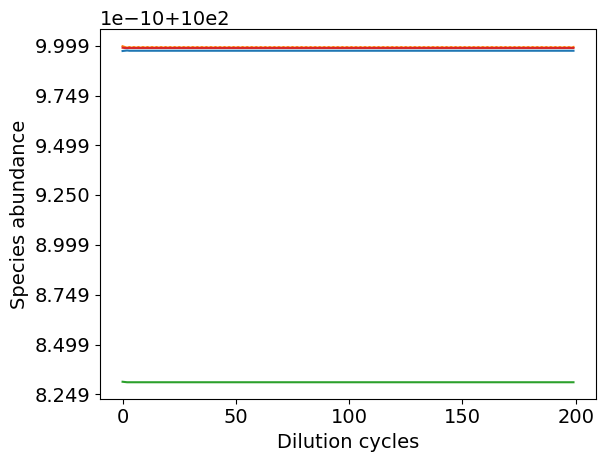

In [119]:
bs = [1,1,1,1]
for idx, spc in enumerate(species_list):
    spc.b = bs[idx]
    spc.RezeroLag()
Rs = np.sum(F, axis=1)
C = EcoSystem(species_list)
b_list, id_list = [], []
for i in tqdm(range(200)):
    C.OneCycle(Rs, T_dilute)
    b_list.append(C.last_cycle['bs'][-1])
    id_list.append(C.last_cycle['ids'])
    C.MoveToNext(D)
vis_biomass(id_list, b_list)

In [21]:
Nseq, Ncout = 0, 1
all_t_deps[(Nseq, Ncout)] = []
for rho in tqdm(rholist):
    t_deps = []
    for idx, trial in enumerate(range(N_trials)):
        g_seq = generate_g(Nseq, R, gmean, gsigma)
        g_cout = generate_g(Ncout, R, gmean, gsigma)
        permutations = list(itertools.permutations(list(range(1, R+1))))
        pref_list = np.array(random.choices(permutations, k=Nseq))
        col = np.argmax(g_seq, axis=1) # find column in g where it's the largest
        for row_i, row in enumerate(pref_list):
            index = np.where(row==col[row_i]+1)[0][0] # and switch this resource with the first-consumed one
            row[0], row[index] = row[index], row[0]
        species_list = []
        for i in range(Nseq):
            species_list.append(SeqUt_alt(rho=rho, g_enz=g_seq[i], gC=gC, pref_list=pref_list[i], biomass=0.01, id=N_inv+i))
        for i in np.arange(Nseq, Nseq+Ncout):
            species_list.append(CoUt_alt(rho=rho, g_enz=g_cout[i-Nseq], gC=gC, biomass=0.01, id=N_inv+i))
        tau_init_dist = lambda x: np.random.uniform(2, 3)
        tau_0_dist = lambda x: np.random.uniform(0.2, 0.4)*2
        for species in species_list:
            tau0 = tau_0_dist(0)
            tau_init = tau_init_dist(0)
            if(species.cat=="Seq"):
                species.SetLag(tau0, TaufSeq, tau_init)
                species.b = 0.01
            else:
                species.SetLag(tau0, TaufCout, tau_init)
                species.b = 0.01
            species.RezeroLag()
        bs = [1,1,1,1]
        for jdx, spc in enumerate(species_list):
            spc.b = bs[jdx]
            spc.RezeroLag()
        Rs = np.sum(F, axis=1)
        C = EcoSystem(species_list)
        b_list, id_list = [], []
        for i in range(100):
            C.OneCycle(Rs, T_dilute)
            b_list.append(C.last_cycle['bs'][-1])
            id_list.append(C.last_cycle['ids'])
            C.MoveToNext(D)
        t_deps.append(C.last_cycle["ts"][-2])
    all_t_deps[(Nseq, Ncout)].append(t_deps)

100%|███████████████████████████████████████████| 40/40 [03:09<00:00,  4.74s/it]


In [22]:
Nseq, Ncout = 1, 0
all_t_deps[(Nseq, Ncout)] = []
for rho in tqdm(rholist):
    t_deps = []
    for idx, trial in enumerate(range(N_trials)):
        g_seq = generate_g(Nseq, R, gmean, gsigma)
        g_cout = generate_g(Ncout, R, gmean, gsigma)
        permutations = list(itertools.permutations(list(range(1, R+1))))
        pref_list = np.array(random.choices(permutations, k=Nseq))
        col = np.argmax(g_seq, axis=1) # find column in g where it's the largest
        for row_i, row in enumerate(pref_list):
            index = np.where(row==col[row_i]+1)[0][0] # and switch this resource with the first-consumed one
            row[0], row[index] = row[index], row[0]
        species_list = []
        for i in range(Nseq):
            species_list.append(SeqUt_alt(rho=rho, g_enz=g_seq[i], gC=gC, pref_list=pref_list[i], biomass=0.01, id=N_inv+i))
        for i in np.arange(Nseq, Nseq+Ncout):
            species_list.append(CoUt_alt(rho=rho, g_enz=g_cout[i-Nseq], gC=gC, biomass=0.01, id=N_inv+i))
        tau_init_dist = lambda x: np.random.uniform(2, 3)
        tau_0_dist = lambda x: np.random.uniform(0.2, 0.4)*2
        for species in species_list:
            tau0 = tau_0_dist(0)
            tau_init = tau_init_dist(0)
            if(species.cat=="Seq"):
                species.SetLag(tau0, TaufSeq, tau_init)
                species.b = 0.01
            else:
                species.SetLag(tau0, TaufCout, tau_init)
                species.b = 0.01
            species.RezeroLag()
        bs = [1,1,1,1]
        for jdx, spc in enumerate(species_list):
            spc.b = bs[jdx]
            spc.RezeroLag()
        Rs = np.sum(F, axis=1)
        C = EcoSystem(species_list)
        b_list, id_list = [], []
        for i in range(100):
            C.OneCycle(Rs, T_dilute)
            b_list.append(C.last_cycle['bs'][-1])
            id_list.append(C.last_cycle['ids'])
            C.MoveToNext(D)
        t_deps.append(C.last_cycle["ts"][-2])
    all_t_deps[(Nseq, Ncout)].append(t_deps)

100%|███████████████████████████████████████████| 40/40 [01:23<00:00,  2.09s/it]


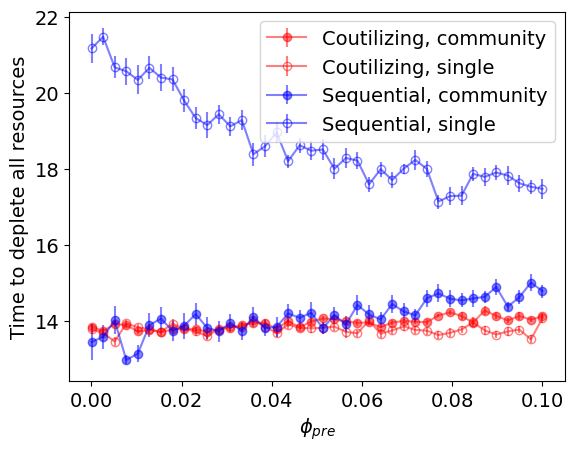

In [43]:
plt.errorbar(rholist/4, [np.mean(i) for i in all_t_deps[(0, 4)]], yerr=[np.std(i)/sqrt(len(i)) for i in all_t_deps[(0, 4)]], marker="o", 
             color="r", alpha=0.5, label="Coutilizing, community")
plt.errorbar(rholist/4, [np.mean(i) for i in all_t_deps[(0, 1)]], yerr=[np.std(i)/sqrt(len(i)) for i in all_t_deps[(0, 1)]], marker="o", 
             markerfacecolor='none', color="r", alpha=0.5, label="Coutilizing, single")
plt.errorbar(rholist/4, [np.mean(i) for i in all_t_deps[(4, 0)]], yerr=[np.std(i)/sqrt(len(i)) for i in all_t_deps[(4, 0)]], marker="o", 
             color="b", alpha=0.5, label="Sequential, community")
plt.errorbar(rholist/4, [np.mean(i) for i in all_t_deps[(1, 0)]], yerr=[np.std(i)/sqrt(len(i)) for i in all_t_deps[(1, 0)]], marker="o", 
             markerfacecolor='none', color="b", alpha=0.5, label="Sequential, single")
plt.xlabel("$\\phi_{pre}$")
plt.ylabel("Time to deplete all resources")
plt.legend()
plt.show()

<ErrorbarContainer object of 3 artists>

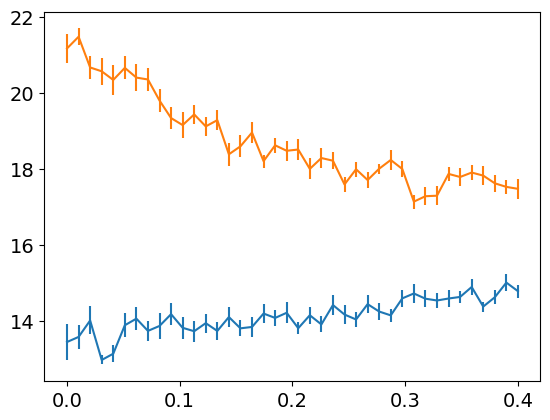

In [27]:
plt.errorbar(rholist, [np.mean(i) for i in all_t_deps[(4, 0)]], yerr=[np.std(i)/sqrt(len(i)) for i in all_t_deps[(4, 0)]])
plt.errorbar(rholist, [np.mean(i) for i in all_t_deps[(1, 0)]], yerr=[np.std(i)/sqrt(len(i)) for i in all_t_deps[(1, 0)]])

In [111]:
for spc in species_list:
    spc.lag_left=0
    spc.GetEating([1, 1, 1, 1])
    print(spc.tau_init, spc.GetGrowthRate())

2.5970971326241026 0.6734008747982022
2.5090918081519327 0.7228729260903121
2.6546772931153937 0.6968345525740179
2.1220597407208976 0.7000135347746486
